<a href="https://colab.research.google.com/github/AndreassOlsson/faceID/blob/main/autoencoder_for_face_landmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The original thought was to use autoencoders on facial landmarks and reconstruction error to draw conclusions about a persons identity. However, the implementation below does not achieve good results.

# Get data

In [ ]:
!pip install mediapipe
from fastai.vision.all import *
import tarfile
import cv2
import mediapipe as mp
import ast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 54.7 MB/s 


### Unzipping, untaring & extracting all image files

In [ ]:
path = "drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lfw-dfun-extracted-nm.tgz" 
# path = "drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lfw-sub-extracted-nm.tgz" 
tar = tarfile.open(path)
tarfile.open(path, 'r:gz').extractall('dfun-e')

In [ ]:
# path_orig = Path('dataset/lfw-deepfunneled/')
path_orig = Path('dfun-e/dfun_e')

people = list(path_orig.ls())
paths = list(set(filter(lambda folder: len(folder.ls())>1, people)))

In [ ]:
import itertools

def f(path):
  return get_image_files(path)

items = list(map(f, paths))
items = L(list(itertools.chain.from_iterable([[j for j in i] for i in items])))

# Apply facemesh to data

In [ ]:
def get_faceLandmarks(image_files, conf=0.5):
  with mp.solutions.face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=conf) as face_mesh:
    orig = image_files
    if not isinstance(image_files, list) and not isinstance(image_files, L): image_files = [image_files]

    images = [cv2.imread(str(file)) for file in image_files]
    results = [face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in images]
    landmarks = [result.multi_face_landmarks for result in results]

    ts = []
    for lm in landmarks:
      try:
        strs = str(lm[0]).split('landmark ')[1:]
        strs = [s.replace('\n','').replace(' x:','').replace('  y:','').replace('  z:','').replace(' ',',').replace('{,,','[').replace('}',']') for s in strs]
        ts.append(torch.tensor([ast.literal_eval(s) for s in strs]))
      except:
        ts.append('NoFaceFound')

    return ts[0] if not isinstance(orig, list) and not isinstance(orig, L) else ts

In [ ]:
def visualize_faceLandmarks(image_files, conf=0.5):
  if not isinstance(image_files, list) and not isinstance(image_files, L): image_files = [image_files]
  for image_file in image_files:
    t = get_faceLandmarks(image_file, conf)
    if t == 'NoFaceFound': continue
    img = PILImage.create(image_file)

    fig = plt.figure(figsize=(10,5))

    # Subplot 1
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(list(t[:,0]), list(t[:,1]), list(t[:,2]))
    ax.set_xlabel('$X$',fontsize=10)
    ax.set_ylabel('$Y$',fontsize=10)
    ax.set_zlabel('$Z$',fontsize=10)
    ax.view_init(-90, -90)

    # Subplot 2
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(img)

    plt.show()

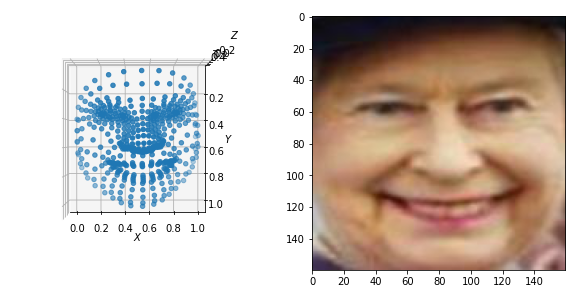

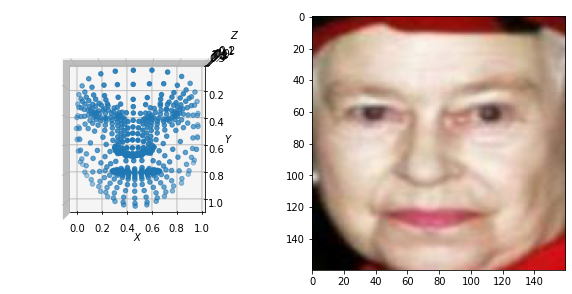

In [ ]:
visualize_faceLandmarks(items[5:7])

In [ ]:
def label_func(fn): return parent_label(fn)
labels = list(set(items.map(label_func)))

In [ ]:
lbl2files = {l: [f for f in items if label_func(f) == l] for l in labels}

In [ ]:
lbl2landmarks = {k: [f for f in get_faceLandmarks(v) if f != 'NoFaceFound'] for k,v in lbl2files.items()}
lbl2landmarks = {k: v for k,v in lbl2landmarks.items() if len(v) > 1}; lbl2landmarks

In [ ]:
len(lbl2landmarks)

1614

In [ ]:
with open('/content/drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lbl2landmarks_dfun.pkl', 'wb') as handle:
    pickle.dump(lbl2landmarks, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lbl2landmarks_dfun.pkl', 'rb') as handle:
    p = pickle.load(handle)

In [ ]:
len(p)

1614

# Create AutoEncoder


In [ ]:
from fastai import *
from fastai.vision.all import *
import pickle
import numpy as np
import pandas as pd
import itertools

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [ ]:
with open('/content/drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lbl2landmarks_dfun.pkl', 'rb') as handle:
    lbl2landmarks = pickle.load(handle)

In [ ]:
class lmsDataset(Dataset):
  def __init__(self, is_valid=False):
    files = L(itertools.chain.from_iterable(lbl2landmarks.values()))
    split = RandomSplitter(0.3, seed=42)(files)[int(is_valid)]
    self.landmarks = files[split]

  def __getitem__(self, idx):
    t = self.landmarks[idx]
    return (t - t.min() ) / (t.max() - t.min())

  def __len__(self):
    return len(self.landmarks)

In [ ]:
train_dset = lmsDataset()
valid_dset = lmsDataset(True)

In [ ]:
dl = torch.utils.data.DataLoader(dataset = train_dset,
                                     batch_size = 64,
                                     shuffle = True)

In [ ]:
def plot_lms(t):
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.scatter(list(t[:,0]), list(t[:,1]), list(t[:,2]))
  ax.set_xlabel('$X$',fontsize=10)
  ax.set_ylabel('$Y$',fontsize=10)
  ax.set_zlabel('$Z$',fontsize=10)
  ax.view_init(-90, -90)
  plt.show()

tensor([[0.5036, 0.7439, 0.0879],
        [0.4966, 0.6275, 0.0108],
        [0.5023, 0.6630, 0.0944],
        ...,
        [0.7231, 0.4432, 0.1932],
        [0.6934, 0.4636, 0.1932],
        [0.7139, 0.4922, 0.1932]])


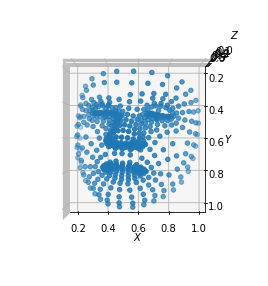

In [ ]:
print(dl.dataset[0]);  plot_lms(dl.dataset[0])

In [ ]:
class AutoEncoder(torch.nn.Module):
# 478*3 ==> 128 ==> 478*3
	def __init__(self):
		super().__init__()

		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(1434, 64),
		)
		
		self.decoder = torch.nn.Sequential(
      torch.nn.Linear(64, 1434)     
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [ ]:
model = AutoEncoder()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [ ]:
epochs = 15
output = []

for epoch in range(epochs):
  for lms in dl:
    lms = lms.reshape(-1,1434)
    recon = model(lms)
    loss = loss_func(recon, lms)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  
  
  print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
  output.append((epoch,lms,recon))


Epoch: 1, Loss: 0.0891
Epoch: 2, Loss: 0.0031
Epoch: 3, Loss: 0.0034
Epoch: 4, Loss: 0.0029
Epoch: 5, Loss: 0.0030
Epoch: 6, Loss: 0.0028
Epoch: 7, Loss: 0.0036
Epoch: 8, Loss: 0.0019
Epoch: 9, Loss: 0.0021
Epoch: 10, Loss: 0.0025
Epoch: 11, Loss: 0.0040
Epoch: 12, Loss: 0.0032
Epoch: 13, Loss: 0.0038
Epoch: 14, Loss: 0.0022
Epoch: 15, Loss: 0.0066


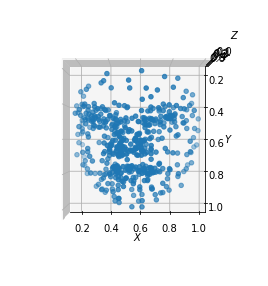

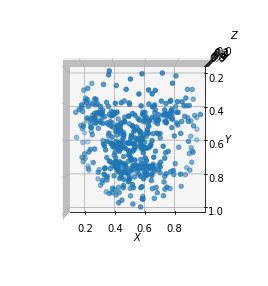

tensor([8.9796, 8.4589, 1.1937])


In [ ]:
t1 = valid_dset[0]
t2 = valid_dset[24]

with torch.no_grad():
  p1 = model(t1.reshape(1,-1)[0]).reshape(-1, 478, 3)[0]
  p2 = model(t2.reshape(1,-1)[0]).reshape(-1, 478, 3)[0]
  plot_lms(p1)
  plot_lms(p2)

  print(sum(p1-p2))


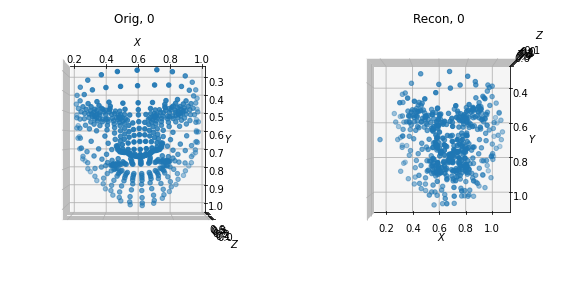

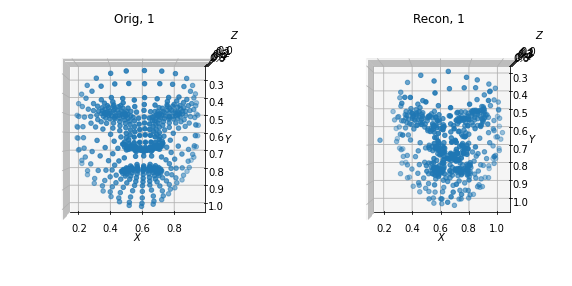

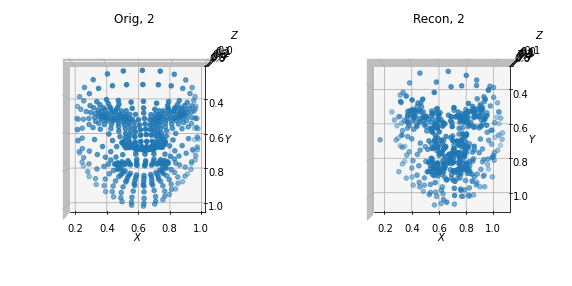

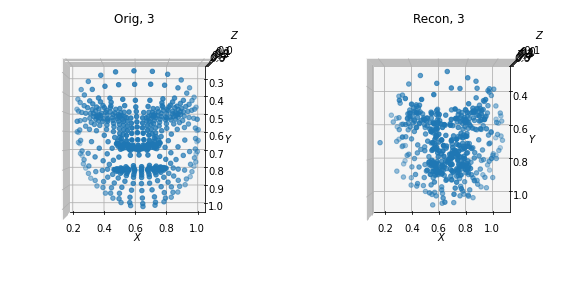

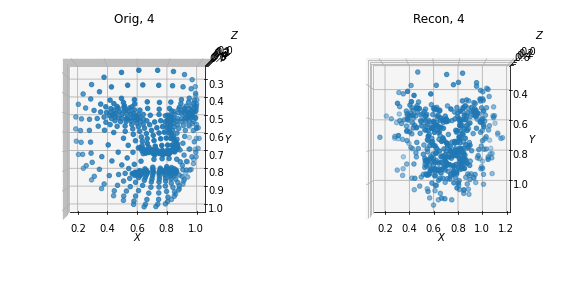

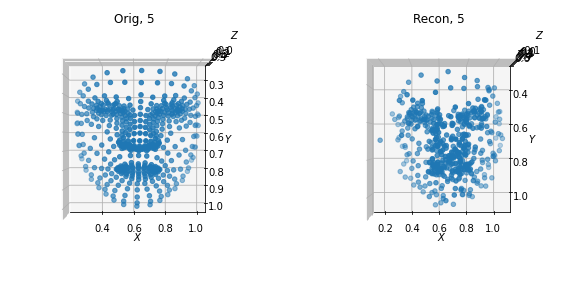

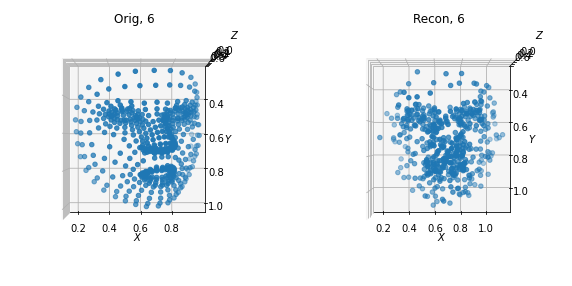

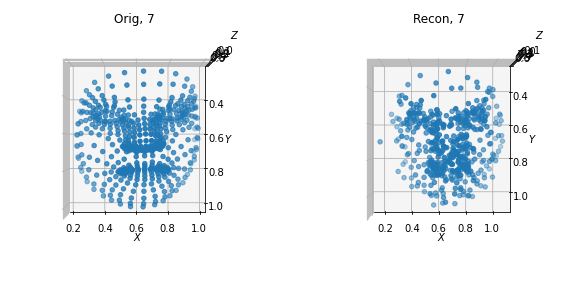

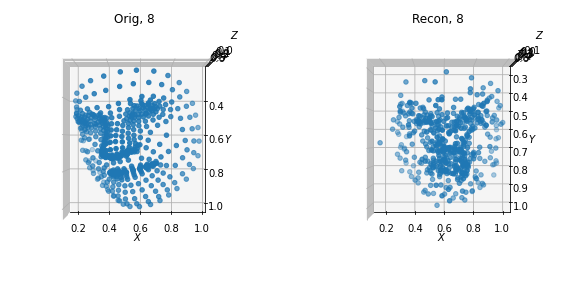

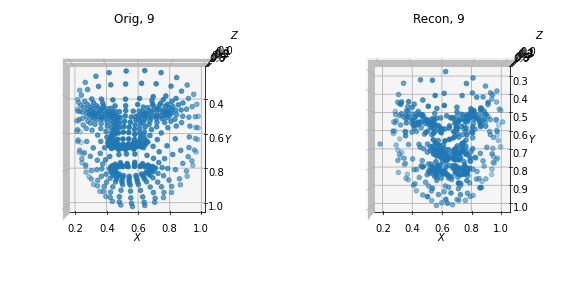

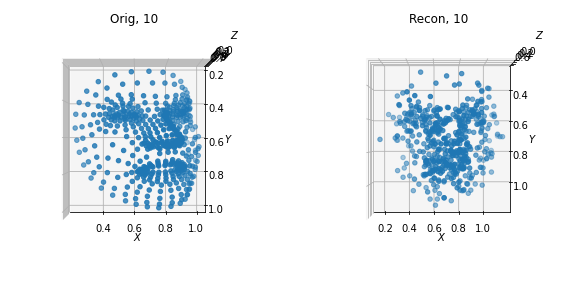

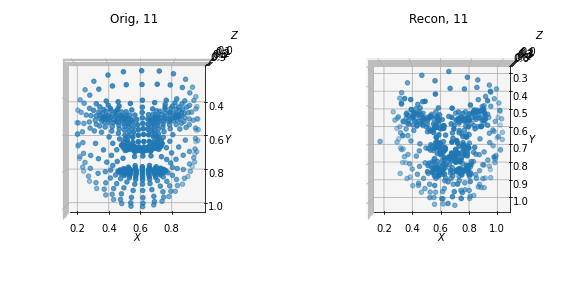

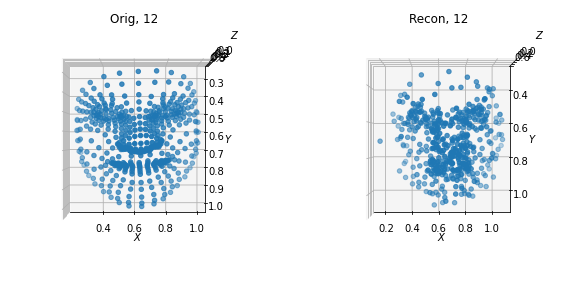

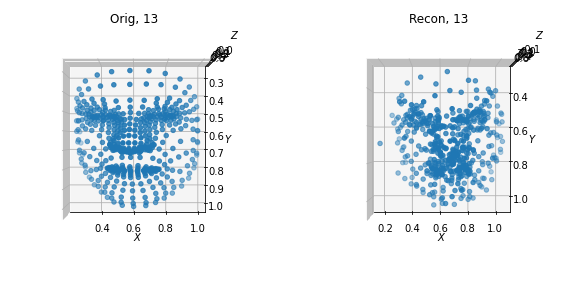

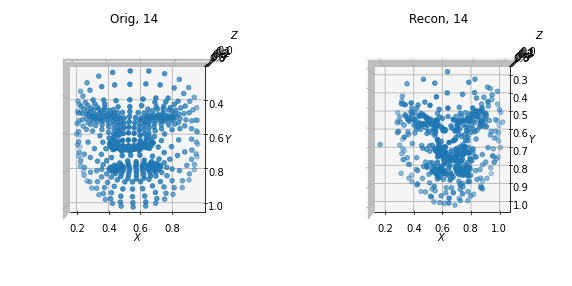

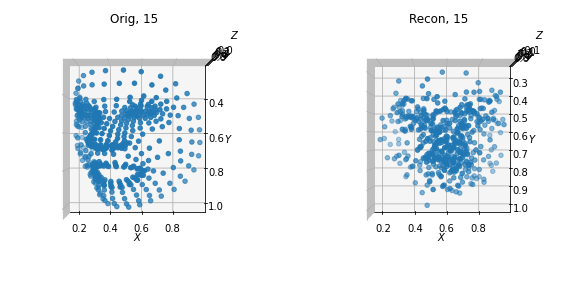

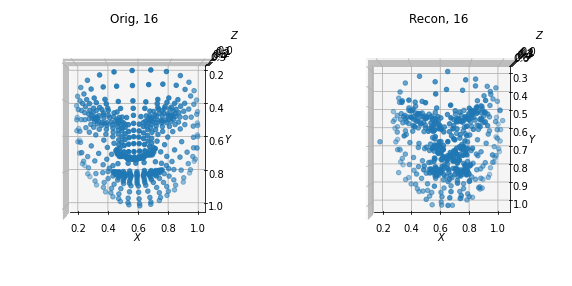

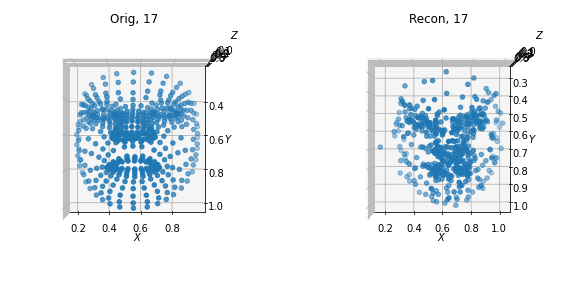

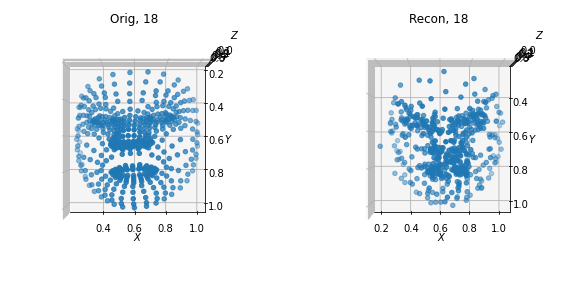

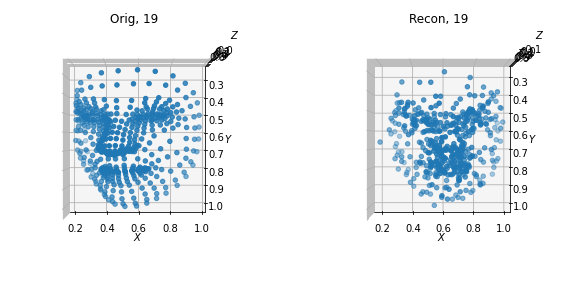

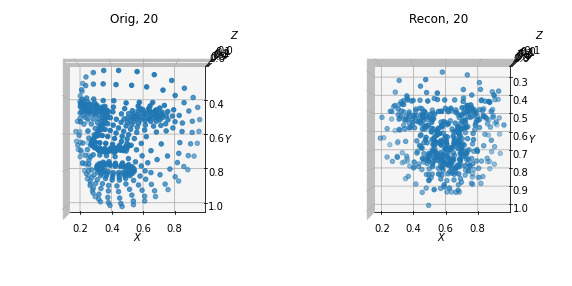

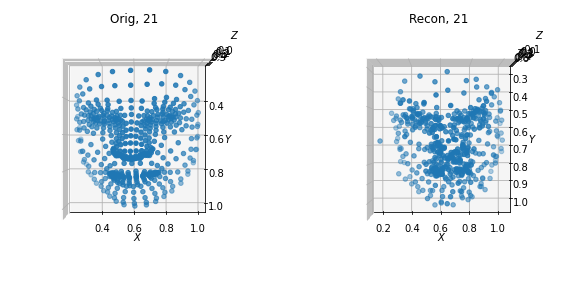

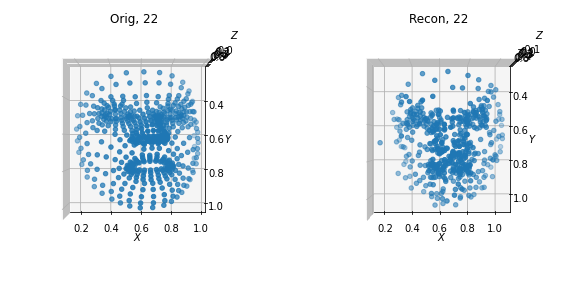

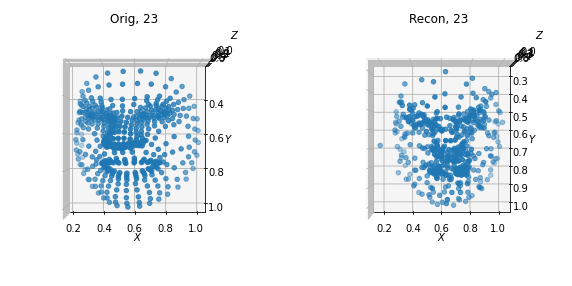

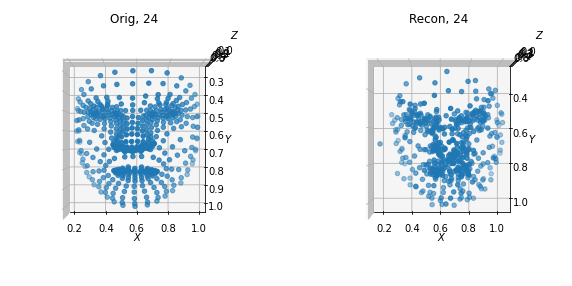

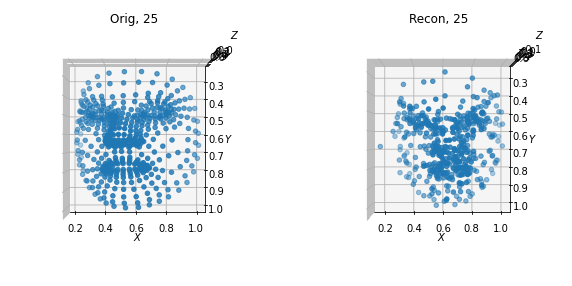

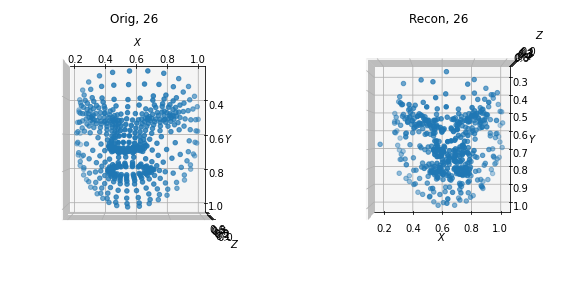

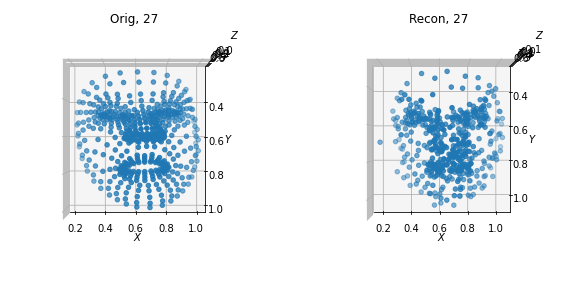

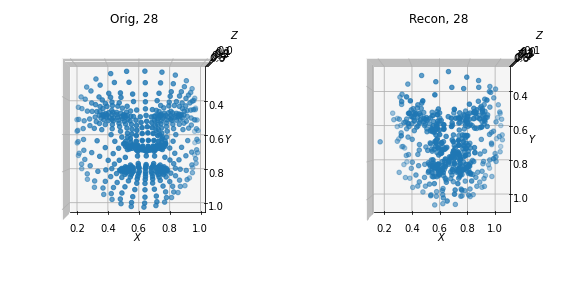

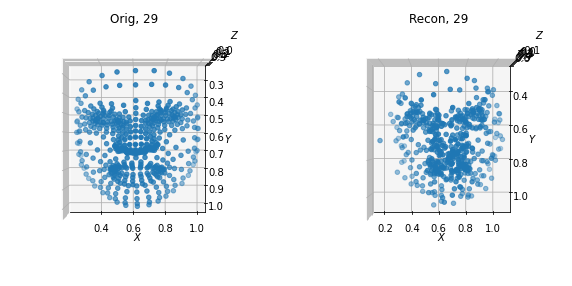

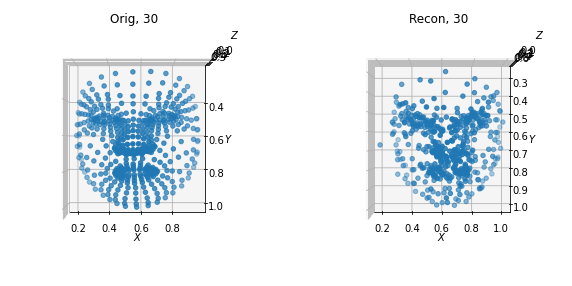

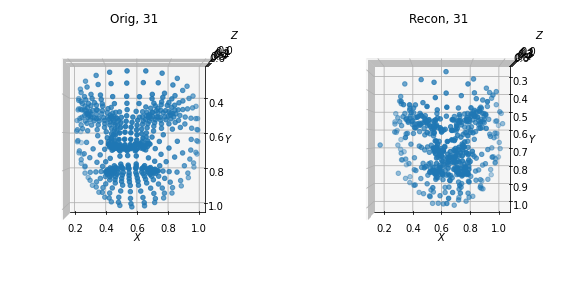

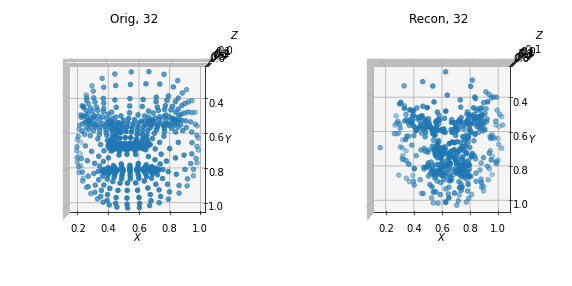

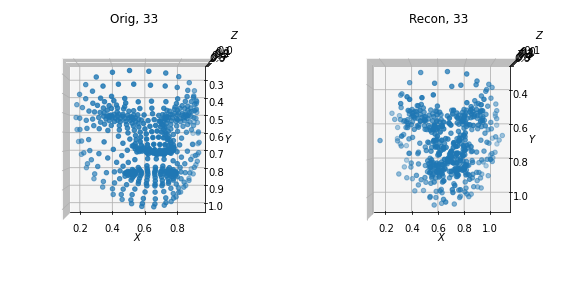

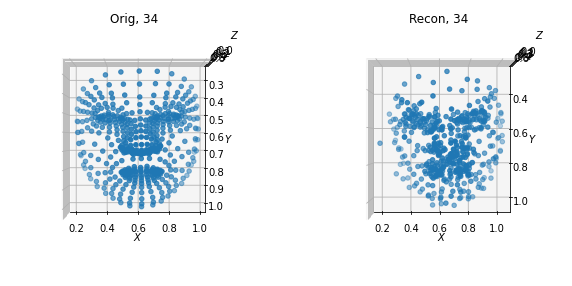

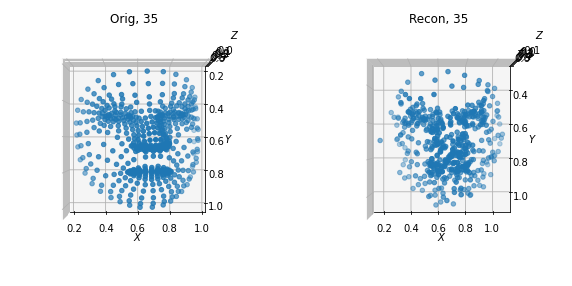

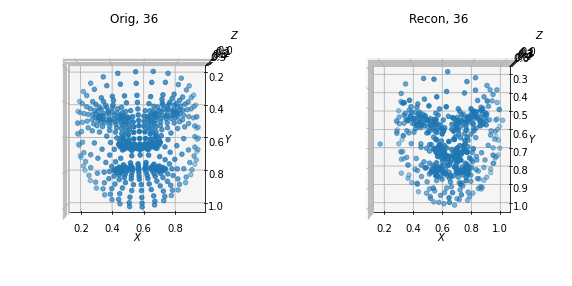

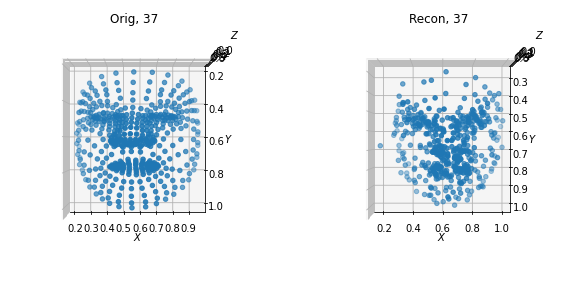

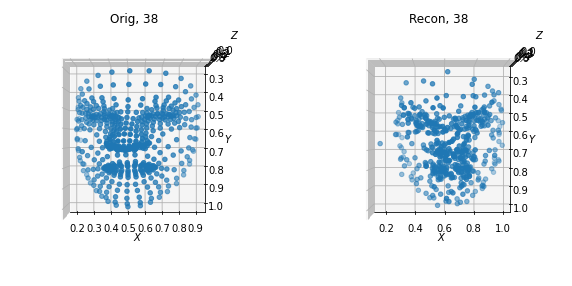

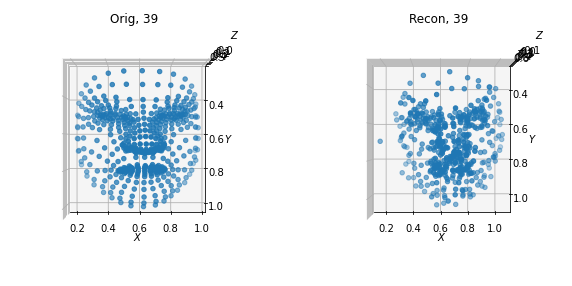

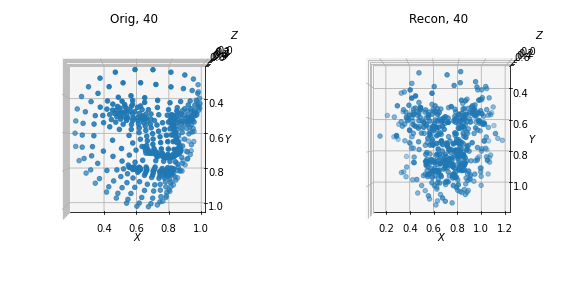

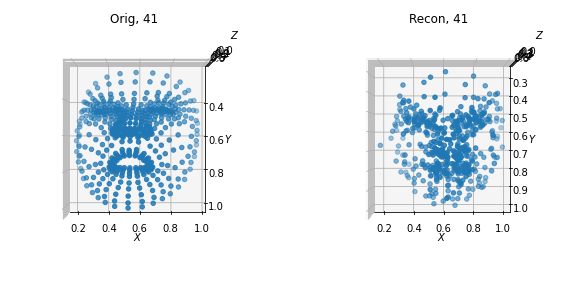

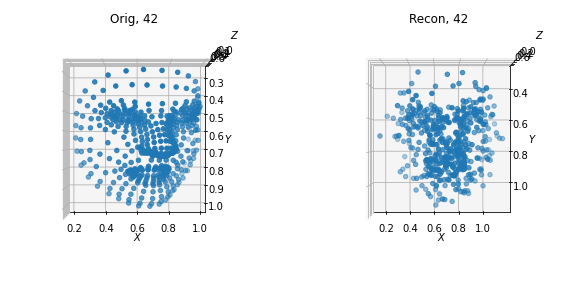

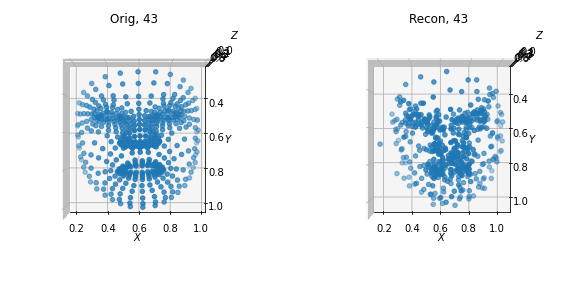

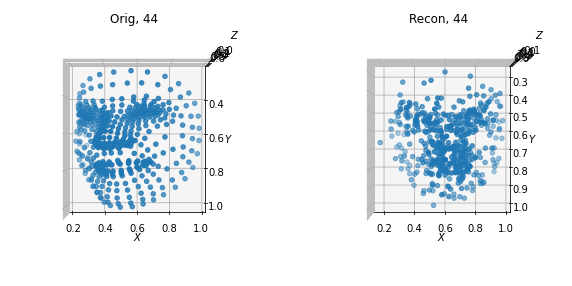

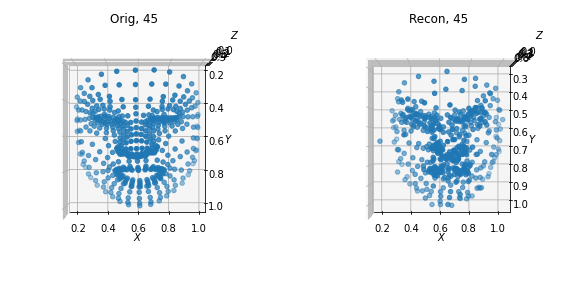

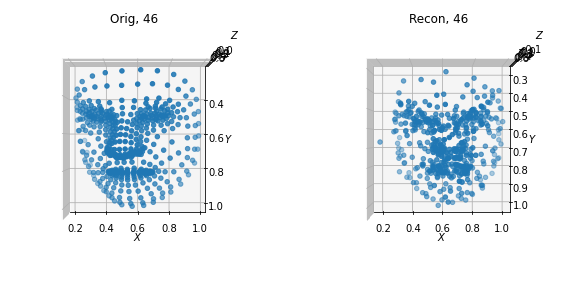

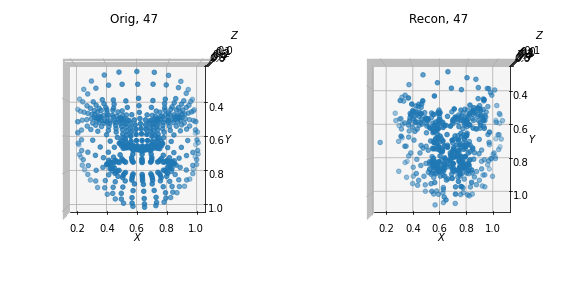

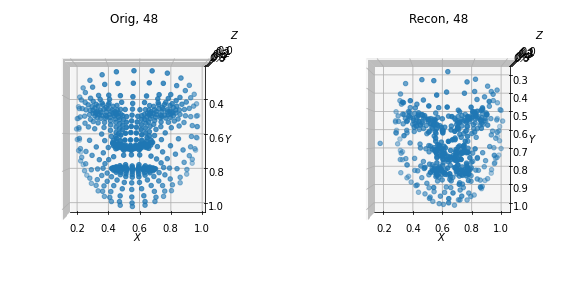

In [ ]:
def plot_results(inputs, reconstructed_inputs):
  with torch.no_grad():
    for n in range(len(inputs)):
      ts = [inputs[n].reshape(-1, 478, 3)[0], reconstructed_inputs[n].reshape(-1, 478, 3)[0]]
      
      fig = plt.figure(figsize=(10,5))
      for i in range(2):  
        t = ts[i]
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        ax.scatter(list(t[:,0]), list(t[:,1]), list(t[:,2]))

        
        ax.set_title(f'Orig, {n}') if i == 0 else ax.set_title(f'Recon, {n}')
  
        ax.set_xlabel('$X$',fontsize=10)
        ax.set_ylabel('$Y$',fontsize=10)
        ax.set_zlabel('$Z$',fontsize=10)
        ax.view_init(-90, -90)
      plt.show()

e, lms, rec = output[-1]
plot_results(lms, rec)

# PCA

In [ ]:
from fastai import *
from fastai.vision.all import *
import pickle
import numpy as np
import pandas as pd
import itertools

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [ ]:
with open('/content/drive/MyDrive/Andreas Olsson/FastAI/faceID/data/lbl2landmarks_dfun.pkl', 'rb') as handle:
    lbl2landmarks = pickle.load(handle)

In [ ]:
class lmsDataset(Dataset):
  def __init__(self, is_valid=False):
    files = L(itertools.chain.from_iterable(lbl2landmarks.values()))
    split = RandomSplitter(0.3, seed=42)(files)[int(is_valid)]
    self.landmarks = files[split]

  def __getitem__(self, idx):
    t = self.landmarks[idx]
    return (t - t.min() ) / (t.max() - t.min())

  def __len__(self):
    return len(self.landmarks)

In [ ]:
train_dset = lmsDataset()
valid_dset = lmsDataset(True)

In [ ]:
dl = torch.utils.data.DataLoader(train_dset, batch_size = 64, shuffle = True)
dl_val = torch.utils.data.DataLoader(valid_dset, batch_size = 64, shuffle = True)
dls = DataLoaders(dl, dl_val)

In [ ]:
l = [np.array(t.reshape(1,-1)[0]) for t in list(train_dset)]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(l)

PCA(n_components=5)

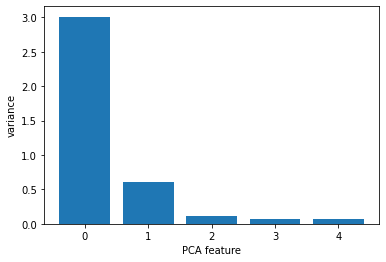

In [ ]:
# Plot the PCA explained variances
features = range(0, pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [ ]:
ts1 = [np.array(((t - t.min() ) / (t.max() - t.min())).reshape(1,-1)[0]) for t in lbl2landmarks[random.choice(list(lbl2landmarks.keys()))]]
ts2 = [np.array(((t - t.min() ) / (t.max() - t.min())).reshape(1,-1)[0]) for t in lbl2landmarks[random.choice(list(lbl2landmarks.keys()))]]

pca_ts1 = pca.transform(ts1)
pca_ts2 = pca.transform(ts2)

# Original values
same = [[np.linalg.norm(t1-t2) for t2 in ts1] for t1 in ts1]
same_avg = sum([sum(ts)/len(ts) for ts in same])/len(same)

dif = [[np.linalg.norm(t1-t2) for t2 in ts2] for t1 in ts1]
dif_avg = sum([sum(ts)/len(ts) for ts in dif])/len(dif)

# PCA values
pca_same = [[np.linalg.norm(t1-t2) for t2 in pca_ts1] for t1 in pca_ts1]
pca_same_avg = sum([sum(ts)/len(ts) for ts in pca_same])/len(pca_same)

pca_dif = [[np.linalg.norm(t1-t2) for t2 in pca_ts2] for t1 in pca_ts1]
pca_dif_avg = sum([sum(ts)/len(ts) for ts in pca_dif])/len(pca_dif)

print('The average euclidean distance between different sets of landmarks tensors:\n')
print(f'Same person: {same_avg:.2f}')
print(f'Different people: {dif_avg:.2f}')
print(f'Difference: {abs(same_avg - dif_avg):.2f}\n')
print(f'Same person PCA: {pca_same_avg:.2f}')
print(f'Different people PCA: {pca_dif_avg:.2f}')
print(f'Difference: {abs(pca_same_avg - pca_dif_avg):.2f}')

The average euclidean distance between different sets of landmarks tensors:

Same person: 2.48
Different people: 3.02
Difference: 0.54

Same person PCA: 2.47
Different people PCA: 2.96
Difference: 0.48


In [ ]:
print('The average euclidean distance between different sets of landmarks tensors:\n')

for _ in range(10):
  ts1 = [np.array(((t - t.min() ) / (t.max() - t.min())).reshape(1,-1)[0]) for t in lbl2landmarks[random.choice(list(lbl2landmarks.keys()))]]
  allTs = list(itertools.chain.from_iterable(ts2))

  ts1 = pca.transform(ts1)
  allTs = pca.transform(allTs)

  same = [[np.linalg.norm(t1-t2) for t1 in ts1] for t2 in ts1]
  same_avg = sum([sum(ts)/len(ts) for ts in same])/len(same)

  dif = [[np.linalg.norm(t1-t2) for t1 in ts1] for t2 in allTs]
  dif_avg = sum([sum(ts)/len(ts) for ts in dif])/len(dif)

  print(f'Same person ({len(same)} lms): {same_avg:.2f}')
  print(f'Different people ({len(dif)} lms): {dif_avg:.2f}')
  print(f'Difference: {-(same_avg - dif_avg):.2f}\n')

The average euclidean distance between different sets of landmarks tensors:

Same person (21 lms): 2.61
Different people (8730 lms): 2.57
Difference: -0.04

Same person (2 lms): 0.92
Different people (8730 lms): 2.35
Difference: 1.43

Same person (2 lms): 0.49
Different people (8730 lms): 1.98
Difference: 1.49

Same person (3 lms): 2.22
Different people (8730 lms): 2.70
Difference: 0.48

Same person (7 lms): 1.59
Different people (8730 lms): 2.15
Difference: 0.55

Same person (2 lms): 1.17
Different people (8730 lms): 2.21
Difference: 1.04

Same person (3 lms): 0.93
Different people (8730 lms): 2.17
Difference: 1.24

Same person (4 lms): 2.16
Different people (8730 lms): 2.67
Difference: 0.51

Same person (2 lms): 0.36
Different people (8730 lms): 2.21
Difference: 1.84

Same person (2 lms): 0.33
Different people (8730 lms): 1.91
Difference: 1.59

